In [14]:
import collections
import datetime
import time
import pandas as pd

from dateutil import rrule
from dateutil.parser import parse
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from beancount.core import data
from beancount.ops import holdings
from beancount import loader
from beancount.reports import holdings_reports

plt.style.use('ggplot')

In [2]:
# Load beancount file

filename = '/home/alex/finance/money.beancount'
entries, errors, options_map = loader.load_file(filename)

In [3]:
#for entry in entries:
#    if isinstance(entry, data.Transaction):
#        dtstart = entry.date
#        break

# Manually set start date, avoids None results
dtstart = datetime.date(2015, 1, 1)

In [4]:
net_worths_dict = collections.defaultdict(list)
index = 0
current_entries = []
dtend = datetime.date.today()
#period = rrule.rrule(rrule.WEEKLY, byweekday=rrule.FR, dtstart=dtstart, until=dtend)
period = rrule.rrule(rrule.MONTHLY, bymonthday=1, dtstart=dtstart, until=dtend)

In [5]:
for dtime in period:
    date = dtime.date()

    # Append new entries until the given date.
    while True:
        entry = entries[index]
        if entry.date >= date:
            break
        current_entries.append(entry)
        index += 1

    # Get the list of holdings.
    raw_holdings_list, price_map = holdings_reports.get_assets_holdings(current_entries,
                                                                        options_map)

    # Convert the currencies.
    for currency in options_map['operating_currency']:
        holdings_list = holdings.convert_to_currency(price_map,
                                                     currency,
                                                     raw_holdings_list)

        holdings_list = holdings.aggregate_holdings_by(
            holdings_list, lambda holding: holding.cost_currency)

        holdings_list = [holding
                         for holding in holdings_list
                         if holding.currency and holding.cost_currency]

        # If after conversion there are no valid holdings, skip the currency
        # altogether.
        if not holdings_list:
            continue

        net_worths_dict[currency].append((date, holdings_list[0].market_value))

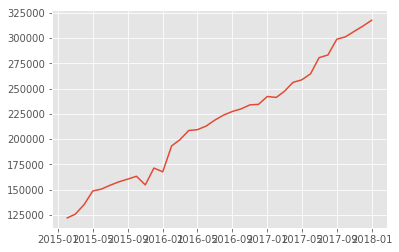

In [6]:
xs, ys = zip(*net_worths_dict['GBP'])
plt.plot(xs, ys)
plt.show()

In [7]:
#Extract data for c3 text for wiki

dates = ['x']
for value in xs:
    dates.append(value.strftime('%Y-%m-%d'))

values = ['Net Worth']
for amount in ys:
    if amount is None:
        amount = 0
    values.append(str(round(float(amount))))

In [8]:
# Build text for dokuwiki

columns = "[{}, {}]".format(dates, values)
c3graphs = r"""
<c3>
data: {x: 'x', 
           columns:""" + columns + r"""
       },
    axis: {x: {
            type: 'timeseries',
            tick: {
                format: '%Y-%m-%d'
            }
        },
        y : {
             label: {
          text: 'GBP',
          position: 'outer-middle'
        }
      }
    }
</c3>
"""

print(c3graphs)


<c3>
data: {x: 'x', 
           columns:[['x', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'], ['Net Worth', '0', '121859', '125581', '135120', '148519', '150487', '154253', '157677', '160350', '163133', '154566', '171264', '167556', '193170', '199339', '208507', '209272', '212900', '218747', '223773', '227395', '229879', '233870', '234381', '242195', '241261', '247142', '256215', '258643', '264559', '280651', '283324', '298940', '301301', '306727', '311872', '317749']]
       },
    axis: {x: {
            type: 'timeseri

In [31]:
# Data for spreadsheet
d = {'Date': xs, 'Networth': ys}
df = pd.DataFrame(data=d)
# format
df['Date'] = pd.to_datetime(df['Date'])
df['Networth'] = pd.to_numeric(df['Networth'])
df = df.round(0)
df

,Date,Networth
0,2015-01-01,$nan
1,2015-02-01,"$121,859.00"
2,2015-03-01,"$125,581.00"
3,2015-04-01,"$135,120.00"
4,2015-05-01,"$148,519.00"
5,2015-06-01,"$150,487.00"
6,2015-07-01,"$154,253.00"
7,2015-08-01,"$157,677.00"
8,2015-09-01,"$160,350.00"
9,2015-10-01,"$163,133.00"


In [32]:
#save to csv
df.to_csv('/home/alex/finance/networth.csv')